# CDOM Processing and Plotting Pipeline

This notebook demonstrates an end-to-end pipeline for processing satellite L2 RRS data to derive, interpolate, and plot CDOM (Colored Dissolved Organic Matter). It performs the following steps:

1.  **Import libraries** and set up the environment.
2.  **Define constants** for CDOM calculation, bounding box, and binning.
3.  **Search for and load** the satellite L2 RRS NetCDF files.
4.  **Inspect RRS data** to confirm variable names.
5.  **Extract RRS data on a GPU** using CuPy and parallel processing via `l2_pipeline`.
6.  **Calculate CDOM**.
7.  **Clip, bin, and apply selective NaN interpolation** to the CDOM data.
8.  **Plot** the rasterized and interpolated CDOM metric.

This pipeline adapts principles from `ogplotter.ipynb` and `test.ipynb` using the `l2_pipeline.py` tools, focusing solely on CDOM.

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, plotting, and the custom processing pipeline.

In [2]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))  # adds project_root to path

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations, e.g. log(0)
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Define Constants and Parameters

This cell defines constants for the CDOM calculation algorithm, the geographical area of interest (bounding box), and parameters for binning the data.

In [3]:
# CDOM Calculation Constants
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# Geographical Bounding Box
lon_min, lon_max = -94.0, -88.0
lat_min, lat_max = 27.5, 30.5

# Binning parameters
lat_bins = 200 # tall
lon_bins = 300 # wide

# L2 RRS Data Configuration
# Directory for L2 RRS NetCDF files. These files are expected to have variables in a 'geophysical_data' group.
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30" # Update this path
# Variables for Remote Sensing Reflectance needed for CDOM calculation.
rrs_vars_list = ['Rrs_412', 'Rrs_555']
# Default group for L2 RRS data in NetCDF files
rrs_data_group = 'geophysical_data'

### Searching for L2 RRS Data Files

Specify the directory containing the L2 RRS NetCDF satellite data files and search for them.

In [4]:
# Specify the data directory for L2 RRS and search recursively for NetCDF files
# IMPORTANT: Update this path to your actual L2 RRS data directory.
# data_dir_l2_rrs is defined in the previous cell
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)

if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}. Please check the path and data.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files.")

# Limiting files for quick testing, remove or adjust as needed for RRS
# nc_files_rrs = nc_files_rrs[:5]
# print(f"Using {len(nc_files_rrs)} L2 RRS files for processing.")

Found 42 L2 RRS files.


In [5]:
# Specify the data directory for L2 RRS and search recursively for NetCDF files
# IMPORTANT: Update this path to your actual L2 RRS data directory.
# data_dir_l2_rrs is defined in the previous cell
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)

if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}. Please check the path and data.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files.")

# Limiting files for quick testing, remove or adjust as needed for RRS
# nc_files_rrs = nc_files_rrs[:5]
# print(f"Using {len(nc_files_rrs)} L2 RRS files for processing.")

Found 42 L2 RRS files.


### Filter Files to One Week Period

This cell filters the found NetCDF files to only include data from a specific week. Modify the `target_week_start` date to select different weeks within your data period.

In [6]:
# Filter files to show only one week of data
from datetime import datetime, timedelta
import re

# Define the target week (modify this date to select different weeks)
target_week_start = "2024-06-01"  # Start of the week you want to analyze (YYYY-MM-DD)
week_start = datetime.strptime(target_week_start, "%Y-%m-%d")
week_end = week_start + timedelta(days=7)

print(f"Filtering files for week: {week_start.strftime('%Y-%m-%d')} to {week_end.strftime('%Y-%m-%d')}")

# Function to extract date from filename
def extract_date_from_filename(filename):
    """Extract date from satellite filename patterns"""
    # Common patterns in satellite filenames (adjust if your filenames differ)
    patterns = [
        r'(\d{4})(\d{2})(\d{2})',  # YYYYMMDD
        r'(\d{4})-(\d{2})-(\d{2})',  # YYYY-MM-DD
        r'(\d{4})(\d{3})',  # YYYYDDD (year + day of year)
    ]
    
    basename = os.path.basename(filename)
    
    for pattern in patterns:
        match = re.search(pattern, basename)
        if match:
            try:
                if len(match.groups()) == 3:  # YYYY MM DD format
                    year, month, day = map(int, match.groups())
                    return datetime(year, month, day)
                elif len(match.groups()) == 2:  # YYYY DDD format (day of year)
                    year, day_of_year = map(int, match.groups())
                    return datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
            except ValueError:
                continue
    return None

# Filter files by date
weekly_nc_files_rrs = []
files_with_dates = 0

for file_path in nc_files_rrs:
    file_date = extract_date_from_filename(file_path)
    if file_date:
        files_with_dates += 1
        if week_start <= file_date < week_end:
            weekly_nc_files_rrs.append(file_path)

print(f"Found dates in {files_with_dates} out of {len(nc_files_rrs)} files")
print(f"Filtered to {len(weekly_nc_files_rrs)} files for the target week")

if weekly_nc_files_rrs:
    # Replace the original file list with the weekly filtered list
    nc_files_rrs = weekly_nc_files_rrs
    print(f"Using {len(nc_files_rrs)} files for weekly CDOM analysis")
else:
    print(f"Warning: No files found for the week {target_week_start}. Using all available files.")
    print("Consider adjusting the target_week_start date or check if your filename format matches the extraction patterns.")

Filtering files for week: 2024-06-01 to 2024-06-08
Found dates in 42 out of 42 files
Filtered to 11 files for the target week
Using 11 files for weekly CDOM analysis


### Inspecting Variables in the RRS Data

The following cell loads the first L2 RRS NetCDF file found and prints its variables, particularly within the expected `geophysical_data` group. Please use this information to:

1.  Confirm the correct variable names for Remote Sensing Reflectance (e.g., 'Rrs_412', 'Rrs_555').
2.  Update the `rrs_vars_list` and `rrs_data_group` in the constants cell if the current values are incorrect for your RRS data.

In [7]:
if nc_files_rrs:
    print(f"Inspecting variables in the first L2 RRS file: {nc_files_rrs[0]}")
    try:
        with xr.open_dataset(nc_files_rrs[0], group=rrs_data_group) as ds_geo:
            print(f"\nVariables in group: '{rrs_data_group}'")
            for var_name_ds in ds_geo.variables:
                print(f"  {var_name_ds}: {ds_geo[var_name_ds].dims} – {ds_geo[var_name_ds].shape} - Attributes: {ds_geo[var_name_ds].attrs}")
            
            found_rrs_vars = list(ds_geo.variables)
            missing_vars = [var for var in rrs_vars_list if var not in found_rrs_vars]
            if not missing_vars:
                print(f"\nAll required RRS variables ({rrs_vars_list}) found in group '{rrs_data_group}'.")
            else:
                print(f"\nWARNING: The following RRS variables were NOT found in group '{rrs_data_group}': {missing_vars}.")
                print(f"  Available variables in group '{rrs_data_group}': {found_rrs_vars}")
                print(f"  Please check `rrs_vars_list` and `rrs_data_group` in the constants cell.")
        
        # Also check navigation data, typically in 'navigation_data' or root
        try:
            with xr.open_dataset(nc_files_rrs[0], group='navigation_data') as ds_nav:
                 print(f"\nVariables in group: 'navigation_data'")
                 for var_name_ds in ds_nav.variables:
                    print(f"  {var_name_ds}: {ds_nav[var_name_ds].dims} – {ds_nav[var_name_ds].shape} - Attributes: {ds_nav[var_name_ds].attrs}")
        except Exception:
            print("\nCould not open or inspect 'navigation_data' group. Latitude/longitude might be in the root or another group.")
            try:
                with xr.open_dataset(nc_files_rrs[0]) as ds_root:
                    print(f"\nVariables in root group:")
                    for var_name_ds in ds_root.variables:
                        print(f"  {var_name_ds}: {ds_root[var_name_ds].dims} – {ds_root[var_name_ds].shape} - Attributes: {ds_root[var_name_ds].attrs}")
            except Exception as e_root:
                 print(f"Could not open or inspect root group: {e_root}")


    except Exception as e:
        print(f"Error inspecting file {nc_files_rrs[0]} (group '{rrs_data_group}'): {e}")
        print(f"Ensure `rrs_data_group` (currently '{rrs_data_group}') is correct for your L2 RRS files.")
else:
    print("No L2 RRS NetCDF files found to inspect. Cannot verify RRS variable names or coordinates.")

Inspecting variables in the first L2 RRS file: E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30\AQUA_MODIS.20240601T191500.L2.OC.nc

Variables in group: 'geophysical_data'
  aot_869: ('number_of_lines', 'pixels_per_line') – (2030, 1354) - Attributes: {'long_name': 'Aerosol optical thickness at 869 nm', 'standard_name': 'atmosphere_optical_thickness_due_to_ambient_aerosol', 'valid_min': np.int16(0), 'valid_max': np.int16(30000)}
  angstrom: ('number_of_lines', 'pixels_per_line') – (2030, 1354) - Attributes: {'long_name': 'Aerosol Angstrom exponent, 443 to 865 nm', 'standard_name': 'aerosol_angstrom_exponent', 'valid_min': np.int16(-30000), 'valid_max': np.int16(5000)}
  Rrs_412: ('number_of_lines', 'pixels_per_line') – (2030, 1354) - Attributes: {'long_name': 'Remote sensing reflectance at 412 nm', 'units': 'sr^-1', 'standard_name': 'surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air', 'valid_min': np.int16(-30000), 'valid_max': np.int

### Loading L2 RRS Datasets

Using `L2DatasetLoader`, this cell loads L2 RRS datasets. It assumes variables are in the `geophysical_data` group by default (or as specified in `rrs_data_group`).

In [8]:
# Load L2 RRS datasets
datasets_rrs = []
if nc_files_rrs:
    try:
        # Pass the rrs_data_group to the loader.
        # L2DatasetLoader's default for 'group' is 'geophysical_data', so this might be redundant if default is used.
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group) 
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets.")
    except Exception as e:
        print(f"Error loading L2 RRS datasets: {e}")
else:
    print("No L2 RRS files found to load.")

# Initialize placeholder variables for extracted data
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

Successfully loaded 11 L2 RRS datasets.


### GPU Data Extraction for L2 RRS

This cell leverages the GPU (if available and CuPy is installed) via `GPUDataExtractor` to extract and filter latitude, longitude, and RRS variable data from the loaded L2 RRS datasets.

In [9]:
# Extract L2 RRS data
if datasets_rrs:
    try:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list) # Assumes lat/lon are 'latitude'/'longitude'
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction complete. Extracted {len(lon_rrs_flat)} data points.")
        for var in rrs_vars_list:
            if var not in rrs_vars_data_flat or rrs_vars_data_flat[var].size == 0:
                 print(f"Warning: RRS variable '{var}' not found or empty in extracted L2 data.")
                 if var not in rrs_vars_data_flat: rrs_vars_data_flat[var] = np.array([]) # Ensure key exists
    except Exception as e:
        print(f"Error during L2 RRS data extraction: {e}")
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}
else:
    print("No L2 RRS datasets loaded, skipping L2 RRS data extraction.")
    lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

L2 RRS data extraction complete. Extracted 3280805 data points.


### Data Processing: CDOM Calculation

This section processes the extracted RRS data to calculate CDOM.

In [10]:
# Initialize final variables for processing
cdom_values = np.array([])

# Perform calculations only if RRS data was extracted
if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    all_lon_rrs = lon_rrs_flat
    all_lat_rrs = lat_rrs_flat

    # --- CDOM Calculation (using L2 RRS data) ---
    Rss412 = rrs_vars_data_flat.get(rrs_vars_list[0], np.array([]))
    Rss555 = rrs_vars_data_flat.get(rrs_vars_list[1], np.array([]))
    cdom_values = np.full_like(all_lon_rrs, np.nan) # Initialize with NaNs

    if Rss412.size > 0 and Rss555.size > 0 and Rss412.shape == all_lon_rrs.shape and Rss555.shape == all_lon_rrs.shape:
        term_ratio = Rss412 / Rss555
        term_numerator = term_ratio - B0
        term_division = term_numerator / B2
        valid_log_mask = term_division > 0 # Ensure argument of log is positive
        
        # Apply mask before log operation to avoid warnings/errors with invalid values
        cdom_values_temp = np.full_like(term_division, np.nan)
        if np.any(valid_log_mask):
            cdom_values_temp[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
        
        cdom_values = cdom_values_temp # Assign back to the main cdom_values array
        print(f"CDOM calculation complete. Min: {np.nanmin(cdom_values):.4f}, Max: {np.nanmax(cdom_values):.4f}")
        if not np.any(~np.isnan(cdom_values)): print("CDOM calculation resulted in all NaNs.")
    else:
        print("Skipping CDOM calculation: Rrs_412 or Rrs_555 data not available, empty, or shape mismatch.")

    # Filter data for CDOM
    valid_rrs_mask = ~np.isnan(all_lon_rrs) & ~np.isnan(all_lat_rrs) & ~np.isnan(cdom_values)
    final_lon_rrs = all_lon_rrs[valid_rrs_mask]
    final_lat_rrs = all_lat_rrs[valid_rrs_mask]
    final_cdom_raw_rrs = cdom_values[valid_rrs_mask]
    print(f"Filtered NaNs for CDOM data, {len(final_lon_rrs)} valid data points remaining for binning.")

else:
    print("Skipping CDOM data processing: No L2 RRS data extracted or available.")
    final_lon_rrs, final_lat_rrs, final_cdom_raw_rrs = np.array([]), np.array([]), np.array([])

CDOM calculation complete. Min: -inf, Max: 1.0487
Filtered NaNs for CDOM data, 3214239 valid data points remaining for binning.


### Clipping and Binning CDOM Data

The extracted and processed CDOM data points are now clipped to the defined geographical bounding box. Then, a 2D binned statistic (mean) is computed for CDOM.

In [11]:
# Initialize binned data variables
binned_cdom_raw = np.array([[]])
lon_grid, lat_grid = None, None
lat_edges, lon_edges = None, None # Store edges for interpolation and plotting

# Binning for CDOM
if final_lon_rrs.size > 0:
    clip_mask_rrs = (
        (final_lon_rrs >= lon_min) & (final_lon_rrs <= lon_max) &
        (final_lat_rrs >= lat_min) & (final_lat_rrs <= lat_max)
    )
    clipped_lon_rrs = final_lon_rrs[clip_mask_rrs]
    clipped_lat_rrs = final_lat_rrs[clip_mask_rrs]
    clipped_cdom_raw_rrs = final_cdom_raw_rrs[clip_mask_rrs]
    print(f"Clipped CDOM data to bounding box. {len(clipped_lon_rrs)} points remaining.")

    if clipped_lon_rrs.size > 0:
        binned_cdom_raw, lat_edges_temp, lon_edges_temp, _ = binned_statistic_2d(
            clipped_lat_rrs, clipped_lon_rrs, clipped_cdom_raw_rrs,
            statistic='mean', bins=[lat_bins, lon_bins], range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        # Store edges (binned_statistic_2d returns bin edges, pcolormesh needs these)
        lat_edges = lat_edges_temp
        lon_edges = lon_edges_temp
        
        print("2D binning complete for CDOM.")
        # Create meshgrid for potential other plot types or analysis, though pcolormesh uses edges
        lon_grid, lat_grid = np.meshgrid(lon_edges_temp[:-1] + np.diff(lon_edges_temp)/2, 
                                         lat_edges_temp[:-1] + np.diff(lat_edges_temp)/2) # Bin centers
    else:
        print("No CDOM data points within the bounding box to bin.")
else:
    print("No valid CDOM data to clip or bin.")

if lat_edges is None or lon_edges is None:
    print("Warning: CDOM grid edges (lat_edges, lon_edges) not created. Interpolation/Plotting might fail.")

Clipped CDOM data to bounding box. 148480 points remaining.
2D binning complete for CDOM.


### Selective NaN Interpolation for CDOM

This section demonstrates using the `SelectiveInterpolator` to fill small gaps (NaNs) in the binned CDOM data, potentially improving visual continuity while preserving larger NaN regions.

In [12]:
# Initialize interpolated data variable
cdom_selective_interp = np.array([[]])
interpolation_threshold = 128  # Regions with fewer connected NaN bins than this will be interpolated

# Interpolation for CDOM
if 'binned_cdom_raw' in locals() and binned_cdom_raw.shape[0] > 0 and binned_cdom_raw.shape[1] > 0 and lat_edges is not None and lon_edges is not None:
    cdom_selective_interp = SelectiveInterpolator.interpolate(
        binned_cdom_raw, lat_edges, lon_edges, threshold=interpolation_threshold # Pass 1D edges
    )
    print(f"Selective NaN interpolation complete for CDOM (threshold: {interpolation_threshold} bins).")
else:
    print("No binned CDOM data available for selective interpolation, or grid edges not available.")

Selective NaN interpolation complete for CDOM (threshold: 128 bins).


### Plotting Interpolated CDOM

The binned and selectively interpolated CDOM data is visualized on a map using Matplotlib and Cartopy.

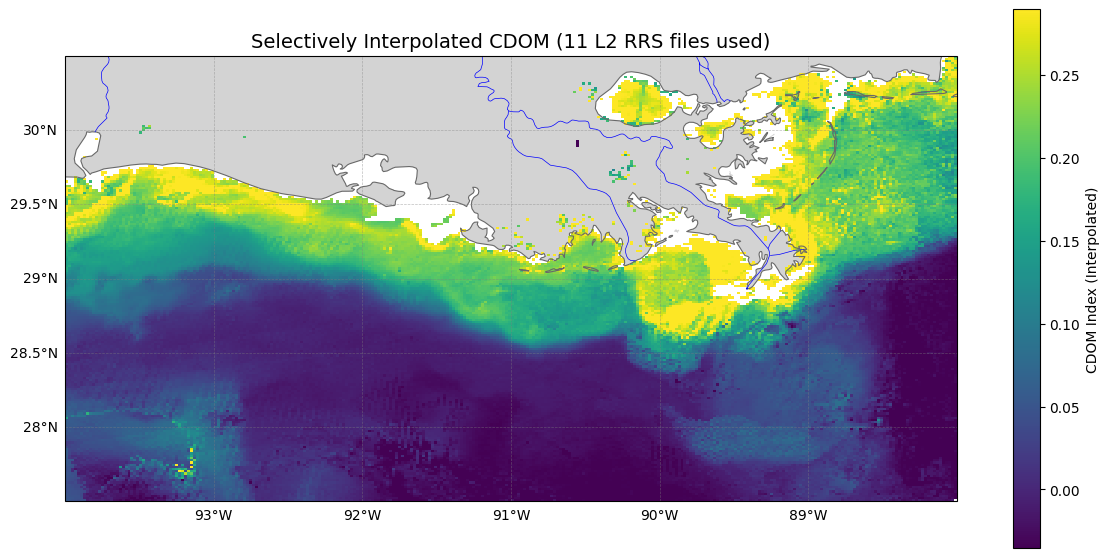

In [18]:
if 'cdom_selective_interp' in locals() and cdom_selective_interp.shape[0] > 0 and cdom_selective_interp.shape[1] > 0 and lon_edges is not None and lat_edges is not None:
    fig_cdom = plt.figure(figsize=(12,8))
    ax_cdom = plt.axes(projection=ccrs.PlateCarree())
    ax_cdom.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax_cdom.set_aspect(1)

    valid_cdom_values = cdom_selective_interp[~np.isnan(cdom_selective_interp)]
    if valid_cdom_values.size > 0:
        vmin_cdom = np.percentile(valid_cdom_values, 5)
        vmax_cdom = np.percentile(valid_cdom_values, 95)
        if vmin_cdom >= vmax_cdom: # Handle cases with low variance
            vmin_cdom = np.nanmin(valid_cdom_values)
            vmax_cdom = np.nanmax(valid_cdom_values)
        if vmin_cdom == vmax_cdom: # Handle cases where all valid values are the same
            vmin_cdom -= 0.01 
            vmax_cdom += 0.01
        if np.isnan(vmin_cdom) or np.isnan(vmax_cdom): # Fallback if percentiles result in NaN
            vmin_cdom = 0 
            vmax_cdom = 0.1
    else: # Fallback if no valid data
        vmin_cdom = 0 
        vmax_cdom = 0.1 

    # Use lon_edges and lat_edges for pcolormesh
    # The dimensions of cdom_selective_interp should be (len(lat_edges)-1, len(lon_edges)-1)
    raster_cdom = ax_cdom.pcolormesh(
        lon_edges, lat_edges, cdom_selective_interp,
        cmap='viridis', shading='auto', 
        transform=ccrs.PlateCarree(),
        vmin=vmin_cdom, vmax=vmax_cdom
    )

    # Add map features
    ax_cdom.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax_cdom.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_cdom.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax_cdom.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

    # Add gridlines
    gl_cdom = ax_cdom.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_cdom.top_labels = False
    gl_cdom.right_labels = False
    
    plt.colorbar(raster_cdom, label='CDOM Index (Interpolated)', shrink=0.7)
    num_files_processed = len(nc_files_rrs) if 'nc_files_rrs' in locals() and nc_files_rrs is not None else 0
    plt.title(f"Selectively Interpolated CDOM ({num_files_processed} L2 RRS files used)", fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No selectively interpolated CDOM data to plot or grid edges not available.")